# Laboratorium

### Konfiguracja

In [2]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [3]:
%matplotlib notebook
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

In [4]:
EPS = 1e-12

# funkcja orienta zwraca wyznacznik macierzy postaci
#  | ax, ay, 1 |
#  | bx, by, 1 |
#  | cx, cy, 1 |
# wyznacznik ten definiuje po jakiej stronie (lewo / prawo)
# znajduje się punkt c względem wektora -ab->
def orient(a, b, c):
    return a[0]*b[1] + a[1]*c[0] + b[0]*c[1] - b[1]*c[0] - a[1]*b[0] - a[0]*c[1]

def inside_polygon(a, b, c, chain):
    o = orient(a,b,c)
    
    if abs(o) < EPS:
        return False
    
    if chain == 1:
        return o < 0
    else:
        return o > 0

# Wczytywanie wielokątu
## Podaj kolejne punkty korzystając z opcji dodaj punkt i klikając w wybrane miejsce na wykresie (punkty muszą być podane w kierunku przeciwnym do kierunku wskazówek zegara)

<IPython.core.display.Javascript object>


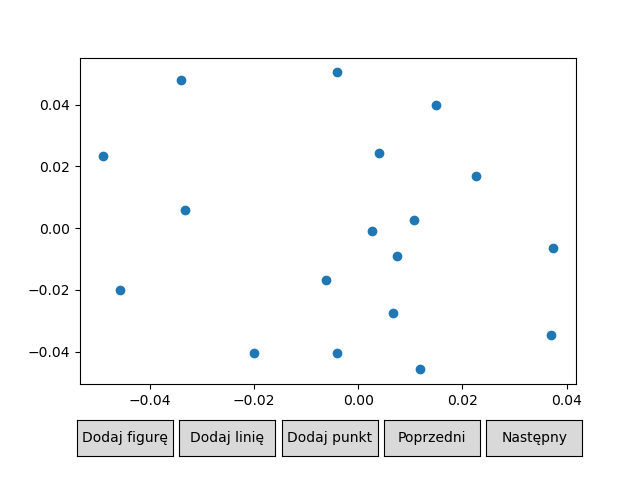

In [9]:
input_plot = Plot()
input_plot.draw()

In [10]:
# input points to lista punktów w postaci dwuelementowych tupli (x, y)
input_points = input_plot.get_added_points()[0].points

## Zapisywanie do pliku (opcjonalnie)

In [7]:
def save_polygon_to_file(points):
    filename = input("Podaj nazwę pliku: ")
    output = open('polygons/' + filename + '.txt', "w")
    for point in points:
        output.write(str(point[0]) + ' ' + str(point[1]) + '\n')
    output.close()
    
save_polygon_to_file(input_points)        

Podaj nazwę pliku: x


## Wyszukiwanie wierzchołków początkowych, końcowych, łączacych, dzielących i prawidłowych

Kolor żółty - wierzchołki początkowe

Kolor czerwony - wierzchołki końcowe

Kolor fioletowy - wierzchołki łączące 

Kolor niebieski - wierzchołki dzielące

Kolor czarny - wierzchołki prawidłowe

Poczatkowych: 2
Koncowych: 2
Lacznie wierzcholkow: 18


<IPython.core.display.Javascript object>


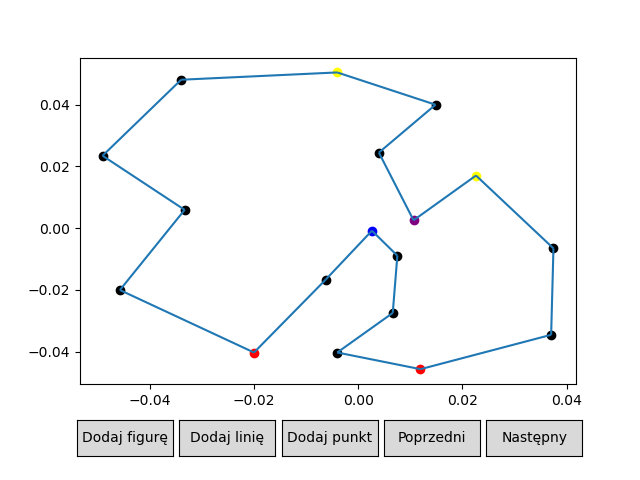

In [11]:
def qualify_vertexes(p):
    n = len(p)
    
    beginning_points  =  []
    ending_points     =  []
    connecting_points =  []
    dividing_points   =  []
    correct_points    =  []
    lines             =  []
    
    for i in range(n):
        prev_point = p[(i-1)%n]
        current_point = p[i]
        next_point = p[(i+1)%n]
        
        o = orient(prev_point, current_point, next_point)
        above = 0
        
        if prev_point[1] > current_point[1]:
            above += 1
        if next_point[1] > current_point[1]:
            above += 1

        if above == 0:
            if o > 0:
                beginning_points.append(current_point)
            else:
                dividing_points.append(current_point)
        elif above == 2:
            if o > 0:
                ending_points.append(current_point)
            else:
                connecting_points.append(current_point)
        else:
            correct_points.append(current_point)
        
        lines.append((current_point, next_point))
    
    print('Poczatkowych: ' + str(len(beginning_points)))
    print('Koncowych: ' + str(len(ending_points)))
    print('Lacznie wierzcholkow: ' + str(n))
    
    scene = [Scene([PointsCollection(beginning_points, color = 'yellow'),
                   PointsCollection(ending_points, color = 'red'),
                   PointsCollection(connecting_points, color = 'purple'),
                   PointsCollection(dividing_points, color = 'blue'),
                   PointsCollection(correct_points, color = 'black')],
                  [LinesCollection(lines)])]
    
    qualify_plot = Plot(scene)
    qualify_plot.draw()

qualify_vertexes(input_points)

## Weryfikowanie monotoniczności wielokąta

In [7]:
def is_y_monotonic(p):
    min_y_val = min(p, key = lambda v : v[1])
    max_y_val = max(p, key = lambda v : v[1])
    
    min_y_index = p.index(min_y_val)
    max_y_index = p.index(max_y_val)
    
    n = len(p)
    
    i, j = (max_y_index - 1)%n, (max_y_index + 1) % n
    
    while i != min_y_index:
        if p[i][1] >= p[(i+1)%n][1]:
            return False
        i = (i-1)%n
    
    while j != min_y_index:
        if p[j][1] >= p[(j-1)%n][1]:
            return False
        j = (j+1)%n
    
    return True

## Klasa punkt

In [8]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.chain = None
        self.index = None
    
    def set_chain(self, chain):
        self.chain = chain
    
    def get_coords(self):
        return (self.x, self.y)

## Przepisanie tablicy punktów do z listy do struktury Point

In [9]:
def map_to_points_and_lines(p):
    n = len(p)
    L = [(p[i], p[(i+1)%n]) for i in range(n)]
    P = [Point(p[i][0], p[i][1]) for i in range(n)]
    
    return P, L

## Triangulacja wielokąta monotonicznego

<IPython.core.display.Javascript object>


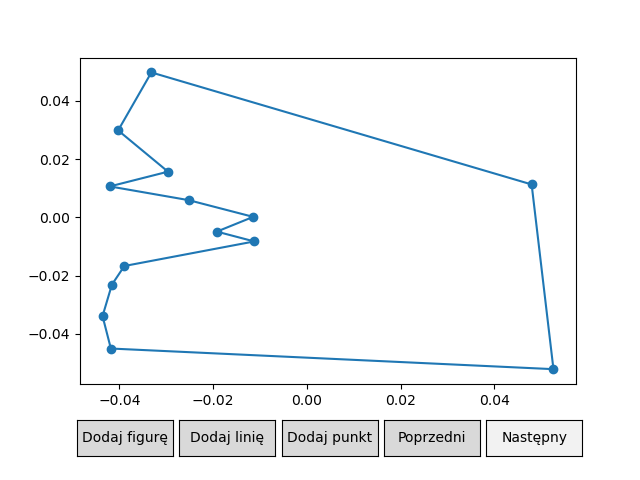

In [11]:
def triangulate(p):
    if not is_y_monotonic(p):
        print('Wielokąt nie jest monotoniczny!')
        return None, None
    
    P, L = map_to_points_and_lines(p)
    n = len(P)
    
    min_index = P.index(min(P, key = lambda v : v.y))
    max_index = P.index(max(P, key = lambda v : v.y))
    
    x = max_index
    while x != min_index:
        P[x].chain = 1
        P[x].index = x
        x = (x+1)%n
    
    while x != max_index:
        P[x].chain = 2
        P[x].index = x
        x = (x+1)%n
    
    P = sorted(P, key = lambda v : v.y, reverse = True)
    
    stack = []
    stack.append(P[0])
    stack.append(P[1])
    scenes = []
    scenes.append(Scene([PointsCollection(p)], [LinesCollection(L)]))
    scenes.append(Scene([PointsCollection(p),
                    PointsCollection([P[0].get_coords(), P[1].get_coords()], color = 'green')],
                    [LinesCollection(L)]))
    diagonals = []
    
    
    
    for i in range(2, n):
        scenes.append(Scene([PointsCollection(p),
                            PointsCollection([P[i].get_coords()], color = 'green')],
                            [LinesCollection(L + diagonals)]))
        if P[i].chain != stack[-1].chain:
            first = stack[-1]
            while len(stack) > 1:
                top = stack.pop()
                if abs(P[i].index - top.index) != 1:
                    diagonals.append((P[i].get_coords(), top.get_coords()))
                    scenes.append(Scene([PointsCollection(p), 
                                         PointsCollection([P[i].get_coords(), top.get_coords()], color = 'red')], 
                                        [LinesCollection(L + diagonals)]))
            stack.pop()
            stack.append(first)
        else:
            top = stack.pop()
            top_prev = stack.pop()
            while inside_polygon(P[i].get_coords(), top.get_coords(), top_prev.get_coords(), P[i].chain):
                if abs(P[i].index - top_prev.index) != 1:
                    diagonals.append((P[i].get_coords(), top_prev.get_coords()))
                    scenes.append(Scene([PointsCollection(p), 
                                         PointsCollection([P[i].get_coords(), top_prev.get_coords()], color = 'red')], 
                                        [LinesCollection(L + diagonals)]))
                if not len(stack):
                    stack = stack + [top_prev]
                    break
                top, top_prev = top_prev, stack.pop()
            else:
                stack = stack + [top_prev, top]
        stack.append(P[i])
    
    scenes.append(Scene([PointsCollection(p)],
                       [LinesCollection(L),
                       LinesCollection(diagonals, color = 'red')]))
    
    return scenes, diagonals


s, d = triangulate(input_points)
triangulate_plot = Plot(s)
triangulate_plot.draw()

## Wczytywanie wielokąta z pliku

In [13]:
def read_from_file(path):
    P = []
    read = open(path, 'r')
    for line in read:
        P.append(list(map(float, line.split())))
    return P
def get_triangulation_plot(points):
    scenes, diagonals = triangulate(points)
    print('Przekatnych ' + str(len(diagonals)-1))
    print('Trojkatow: ' + str(len(diagonals)))
    plot = Plot(scenes)
    return plot

## Kilka zestawów testowych

Przekatnych 8
Trojkatow: 9


<IPython.core.display.Javascript object>


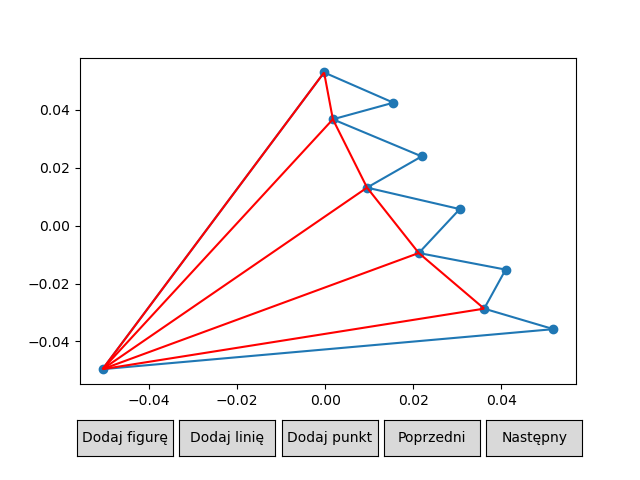

In [37]:
plot = get_triangulation_plot(read_from_file('tests/rocket.txt'))
plot.draw()

Przekatnych 4
Trojkatow: 5


<IPython.core.display.Javascript object>


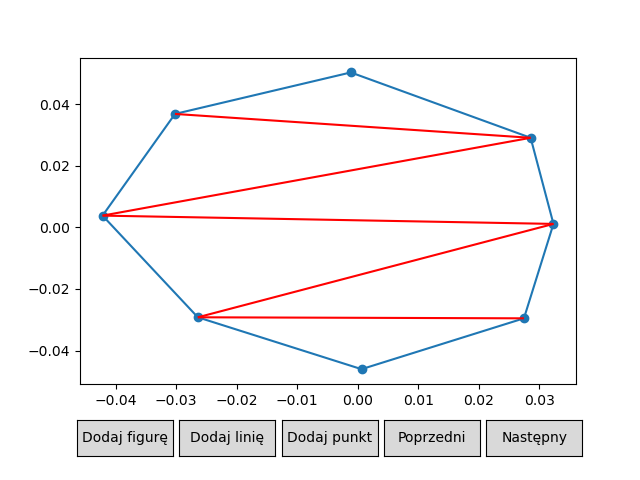

In [36]:
plot = get_triangulation_plot(read_from_file('tests/ball.txt'))
plot.draw()

Przekatnych 14
Trojkatow: 15


<IPython.core.display.Javascript object>


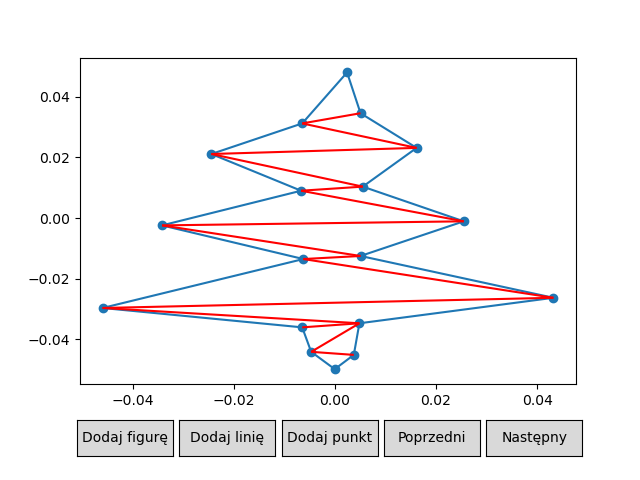

In [14]:
plot = get_triangulation_plot(read_from_file('tests/christmas_tree.txt'))
plot.draw()

Przekatnych 18
Trojkatow: 19


<IPython.core.display.Javascript object>


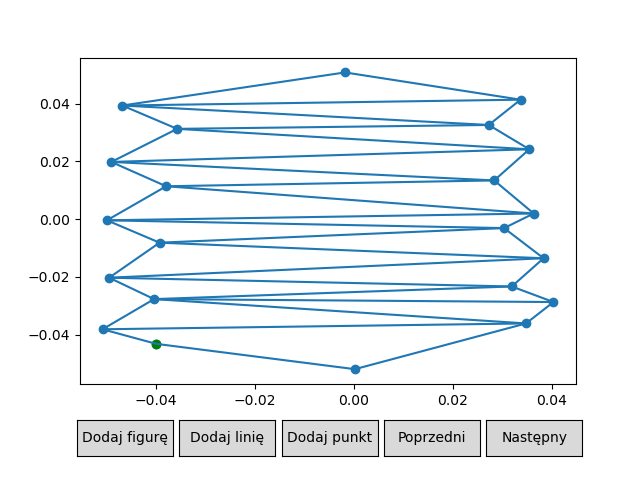

In [15]:
plot = get_triangulation_plot(read_from_file('tests/random1.txt'))
plot.draw()

Przekatnych 12
Trojkatow: 13


<IPython.core.display.Javascript object>


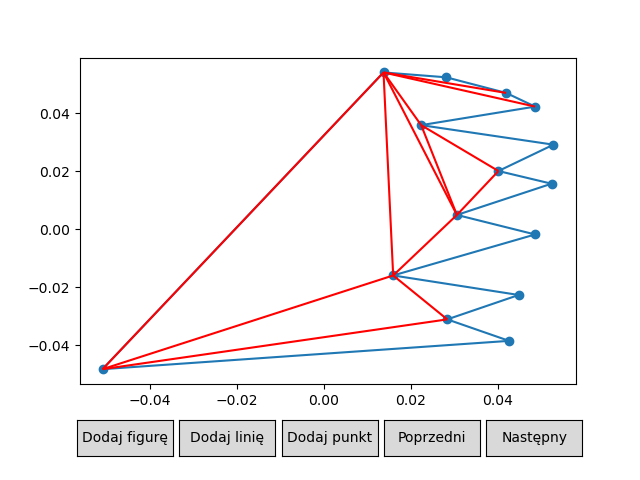

In [35]:
plot = get_triangulation_plot(read_from_file('tests/random2.txt'))
plot.draw()